# (Optional) Load Data from Kaggle into Google Colab

In [84]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T220121Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D463ccdde275b65fe92666a59d75c072196373f7a14f1b8ea67e94aa7b5aef0e7b11403294a8632ed2a05aa1e5a8fc66177b5f07fef7cc7d74c8b79bda39ecf69151f6c6f55a881beb69e0d142111d86c15bd6599f6672966f056be351e01655db635a0ab79502f9a391586a2c2d8141d420ac1d7df1daafad062c2e2e5557af3723baa5fb7dad07845378030e874aa10bd33c176ff7720f8e455ae24e0cb9b76791c709c7faa1e854b6534f40e8aa118f8093c3f9ade37cb67a6a6521e3a8a1cf3a8e2b385d8409354559400cbe9f1b0b1a26ebc190c1c782a299319a6977dc63348392840949853ce1ff5bb82c770d93a63d285e3fa095a5467a9ca6f38f361'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


# Scratch model

The first idea was to train and build a Convolutional Neural Network (CNN) from scratch. After evaluating different libraries like PyTorch and Tensorflow we decided to use keras.

### Imports

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Rescaling
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


## Import the Data and Set Batch Size and Epochs

### Import
The Keras `image_dataset_from_directory` function provides the ability to load images and automatically assign labels based on their directory paths, which fits perfectly our data structure. Additionally, it allows for splitting the data into training and validation subsets and setting the batch size.

### Batch Size and Epochs
The choice of an appropriate batch size and number of epochs is influenced by the optimizer, learning rate, and many other factors. After testing different options, a batch size of 32 and 70 epochs was found to work well. Although 70 epochs might seem high, a technique is used that eventually reduces this number, making the training process more efficient.

In [86]:
base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 32
epochs = 70

In [87]:
# Documentation: https://keras.io/api/data_loading/image/
train_ds, validation_ds = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=420,
    subset="both",
    validation_split=0.15,
    image_size=(100, 100))


class_names = train_ds.class_names

print(train_ds.class_names)

Found 9108 files belonging to 5 classes.
Using 7742 files for training.
Using 1366 files for validation.
['angry', 'fear', 'happy', 'sad', 'surprise']


## Normalization and Random Image Augmentation

### Normalization
All pixels of the grayscale images have values between 0 and 255. These values are normalized to lie between 0 and 1 because it provides several benefits for training Convolutional Neural Networks (CNNs). It stabilizes and makes computations more efficient by keeping the input values within a consistent and small range. This helps avoid numerical instabilities and speeds up convergence during training. Overall, normalization leads to more stable, faster, and improved performance of the neural network.
For consistency we have to normalize all data sets (train, validation, test).


### Random Image Augmentation
To decrease overfitting, we chose to use random data augmentation. This technique randomly modifies the images by, for example, rotating them, flipping them, zooming in or out, or adjusting the contrast and brightness. Keras provides various suitable image preprocessing layers for these augmentations. Selecting the appropriate layers and determining the correct parameters for the transformations is not an easy task.

If the images are augmented too much, the model may struggle to identify the important features that determine the label. Conversely, if the augmentation is too minimal, it does not significantly enhance the model's generalization capabilities.

In the end, we found that the best generalization was achieved by using a random rotation and a random zoom, which independently zooms in and out on each axis and therefore distorts the image to a certain factor.

Random data augmentation is only applied to the training data since it is useful for training the model, but not for validating or testing it.

In [88]:
normalization_layer = Rescaling(1./255)

# Documentation: https://keras.io/api/layers/preprocessing_layers/image_augmentation/
data_augmentation = Sequential([
    # RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomZoom(height_factor=(0.1, 0.1), width_factor=(0.1, 0.1), fill_mode='constant', fill_value=0.0),
    # RandomContrast(0.01),
    # RandomBrightness(0.01)
])
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))

## Create CNN Model Structure

### Convolutional Layer 1
* Number of input Channels: 1 (Greyscale)
* Number of output Channels: 32
* Kernel size: 3x3
* Stride: 1
* Padding: 1
* Activation: ReLU

### Convolutional Layer 2
* Number of input Channels: 32
* Number of output Channels: 64
* Kernel size: 3x3
* Stride: 1
* Padding: 1
* Activation: ReLU

### Max Pooling Layer 1
* Kernel size: 2x2
* Stride: 2
* Padding: 0

### Dropout Layer 1
* Dropout rate: 0.25

### Convolutional Layer 3
* Number of input Channels: 64
* Number of output Channels: 128
* Kernel size: 3x3
* Stride: 1
* Padding: 1
* Activation: ReLU

### Max Pooling Layer 2
* Kernel size: 2x2
* Stride: 2
* Padding: 0

### Convolutional Layer 4
* Number of input Channels: 128
* Number of output Channels: 256
* Kernel size: 3x3
* Stride: 1
* Padding: 1
* Activation: ReLU

### Max Pooling Layer 3
* Kernel size: 2x2
* Stride: 2
* Padding: 0

### Dropout Layer 2
* Dropout rate: 0.25

### Flatten Layer
Converts the multi-dimensional output of the Convolutional and Pooling layers into a 1D vector.

### Fully Connected Layer 1
* Input features: Output size after the last pooling layer, flattened
* Output features: 1028
* Activation: ReLU
* (Regularization: L2)

### Dropout Layer 3
* Dropout rate: 0.5

### Fully Connected Layer 2
* Input features: 1028
* Output features: Number of classes (5 different emotions)
* Activation: Softmax

In [95]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(100,100,1)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),


    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(1028, activation='relu', kernel_regularizer="l2"),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_37 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                               

Try Learning rate of 0.001

In [ ]:
# Define the optimizer
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)


# Compile the model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)



# Training des Modells
history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])


Epoch 1/70
242/242 [==============================] - 10s 35ms/step - loss: 6.2094 - accuracy: 0.2378 - val_loss: 1.8961 - val_accuracy: 0.2357 - lr: 9.9990e-05
Epoch 2/70
242/242 [==============================] - 8s 35ms/step - loss: 1.6908 - accuracy: 0.3073 - val_loss: 1.5970 - val_accuracy: 0.3177 - lr: 9.9980e-05
Epoch 3/70
242/242 [==============================] - 8s 34ms/step - loss: 1.5513 - accuracy: 0.3999 - val_loss: 1.4852 - val_accuracy: 0.4634 - lr: 9.9970e-05
Epoch 4/70
242/242 [==============================] - 8s 34ms/step - loss: 1.4937 - accuracy: 0.4380 - val_loss: 1.4269 - val_accuracy: 0.4817 - lr: 9.9961e-05
Epoch 5/70
242/242 [==============================] - 8s 34ms/step - loss: 1.4358 - accuracy: 0.4831 - val_loss: 1.4039 - val_accuracy: 0.4978 - lr: 9.9951e-05
Epoch 6/70
242/242 [==============================] - 8s 34ms/step - loss: 1.3941 - accuracy: 0.5040 - val_loss: 1.3529 - val_accuracy: 0.5344 - lr: 9.9941e-05
Epoch 7/70
242/242 [===================

In [91]:
# Vorhersagen für die Validierungsdaten
y_val_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_val_pred = model.predict(validation_ds)

# Umwandeln der Vorhersagen in One-Hot-Format
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

# F1-Score berechnen
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

43/43 [==============================] - 0s 6ms/step
F1-Score:  0.6717293731391254


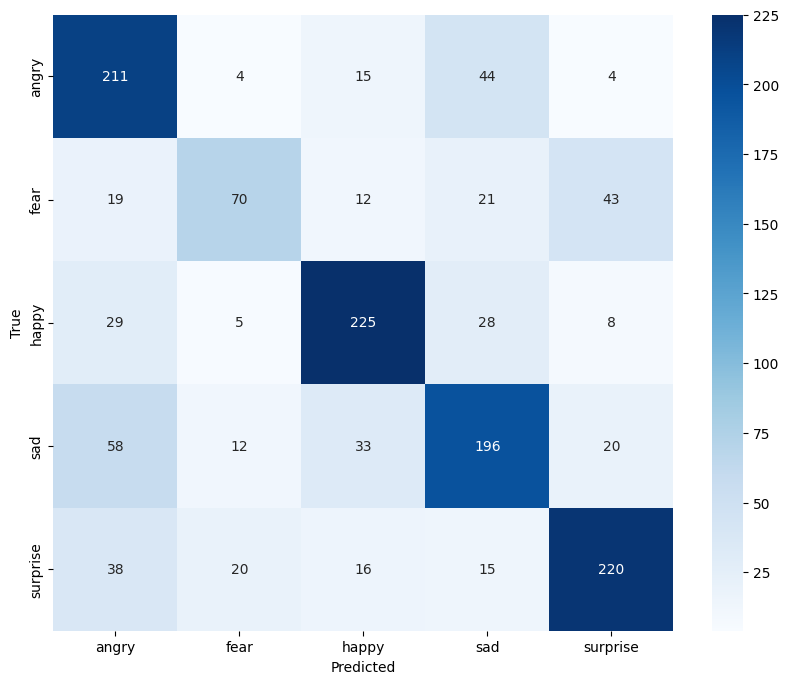

              precision    recall  f1-score   support

       angry       0.59      0.76      0.67       278
        fear       0.63      0.42      0.51       165
       happy       0.75      0.76      0.76       295
         sad       0.64      0.61      0.63       319
    surprise       0.75      0.71      0.73       309

    accuracy                           0.67      1366
   macro avg       0.67      0.65      0.66      1366
weighted avg       0.68      0.67      0.67      1366



In [92]:
# Confusion Matrix und Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


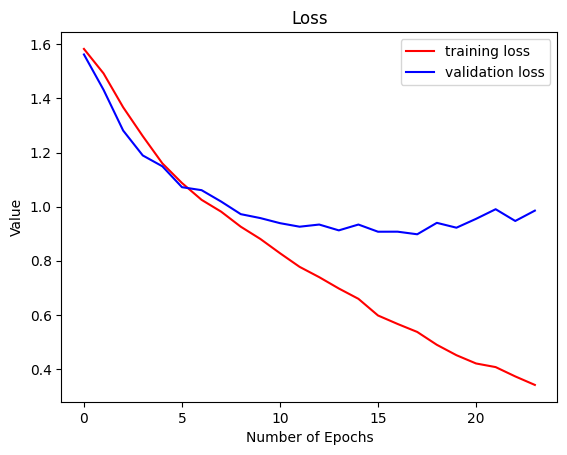

In [93]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['loss'], color='r', label="training loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create Submission

In [94]:
file_names = []
images = []
test_directory = base_directory + 'test/'

for filename in os.listdir(test_directory):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=(100,100), color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = normalization_layer(img_array)
        images.append(img_array)
        file_names.append(filename)

# In ein numpy Array konvertieren
images_array = np.array(images)

# Vorhersagen machen
y_test = model.predict(images_array)
y_pred_indices = np.argmax(y_test, axis=1)
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

# DataFrame erstellen
df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

# DataFrame als CSV speichern
df.to_csv('./submission.csv', index=False)

75/75 [==============================] - 1s 6ms/step
